##  Path Setup ##

##### Python 3.9 may only work for training #####

In [1]:
import os
import wget
import shutil

In [2]:
CUSTOM_MODEL_NAME = 'rs_windows_640x640' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'SCRIPTS_PATH': os.path.join('scripts'),
    'APIMODEL_PATH': '/home/mcserver/Desktop/machineLearning/tensorflow/research/object_detection/',
    'ANNOTATION_PATH': os.path.join('annotations'),
    'IMAGE_PATH': os.path.join('images'),
    'MODEL_PATH': os.path.join('models'),
    'PRETRAINED_MODEL_PATH': os.path.join('pretrained_models'),
    'CHECKPOINT_PATH': os.path.join('models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME),
    'TRAINING_SCRIPT' : os.path.join(paths['APIMODEL_PATH'], 'model_main_tf2.py')
}

## Create Label Map ##

In [5]:
labels = [{'name':'balance', 'id': 1}, {'name':'content', 'id': 2}, {'name':'store', 'id': 3}, {'name':'details', 'id': 4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

##  Create TF Records ##

In [6]:
if not os.path.exists(os.path.join(files['TF_RECORD_SCRIPT'])):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {os.path.join(paths['SCRIPTS_PATH'])}

In [77]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: annotations/train.record
Successfully created the TFRecord file: annotations/test.record


## Download Pretrained Model ##

In [78]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2023-08-10 22:02:47--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2607:f8b0:4007:814::2010, 142.250.68.48
Connecting to download.tensorflow.org (download.tensorflow.org)|2607:f8b0:4007:814::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  1.39MB/s    in 2m 45s  

2023-08-10 22:05:36 (121 KB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_640x640_c

## Copy and Move Config ##

In [7]:
if not os.path.exists(paths['CHECKPOINT_PATH']):
    os.mkdir(paths['CHECKPOINT_PATH'])

In [8]:
shutil.copy(os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config'), paths['CHECKPOINT_PATH'])

'models/rs_windows_640x640/pipeline.config'

## Update Config File ##

In [85]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [86]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config) 

In [87]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [88]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [89]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=3000".format(files['TRAINING_SCRIPT'], paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [90]:
command

'python /home/mcserver/Desktop/machineLearning/tensorflow/research/object_detection/model_main_tf2.py --model_dir=models/rs_640x640 --pipeline_config_path=models/rs_640x640/pipeline.config --num_train_steps=3000'

In [16]:
# test_path = os.path.join(paths["IMAGE_PATH"], "test") 
# classes = ["iphone", "samsung", "xiaomi", "pixel"]
# for file in os.listdir(test_path):
#     for label in classes:
#         if file.startswith(f"{label}_"):
#             new_name = f"{label}_" + file[len(label) + 1:]
#             new_name = os.path.join(test_path, new_name)
#             os.rename(os.path.join(test_path, file), new_name)

In [17]:
# Script to verify valid file types

from pathlib import Path
import imghdr

data_dir = os.path.join(paths["IMAGE_PATH"], "train") 
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [91]:
!{command}

2023-08-10 22:30:35.131340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 22:30:35.215512: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 22:30:36.767317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0810 22:30:39.800927 140257489655616 mirrored_strategy.py:419] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 3000
I0810 22:30:39.836269 140257489655616 config_util.py:552] Maybe overwriting train_steps: 3000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0810 22:30:39.836766 140257489655616 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets

## Evaluate Model ##

In [19]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(files['TRAINING_SCRIPT'], paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
!{command}

## Detection Image Test ## 

In [7]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util


2023-08-12 18:50:14.109823: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 18:50:14.340355: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 18:50:16.672957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-4')).expect_partial()

def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [9]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [ ]:
from PIL import Image
# Reciept images: (1655, 7047)
# Valid images: (1280, 720)
# Current: (413, 2056) <- (413, 1312)

def resize_images(path: str, factor: int):
    for file_name in os.listdir(path):
        if file_name.endswith(".jpg"):
            file_path = os.path.join(path, file_name)
            image = Image.open(file_path)
            width, height = image.size
            target_size = (int(width//factor), int(height//factor))
            resized_image = image.resize(target_size, Image.LANCZOS)
            resized_image.save(file_path)

def show_images_size(path: str):
    for file_name in os.listdir(path):
        if file_name.endswith(".jpg"):
            file_path = os.path.join(path, file_name)
            image = Image.open(file_path)
            print(image.size)

def remove_xml(path: str):
    for file_name in os.listdir(path):
        if file_name.endswith(".xml"):
            os.remove(os.path.join(path, file_name))

In [ ]:
TESTING_IMAGES_PATH = os.path.join(paths['IMAGE_PATH'], 'collected','raw')
resize_images(TESTING_IMAGES_PATH, 0.25)

In [12]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'train', 'balance_6028e636-33e1-11ee-a805-984827e0aa99.jpg')

100


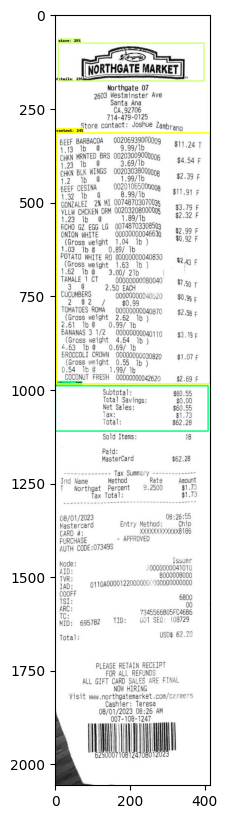

In [13]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)


num_detections = int(detections.pop('num_detections'))

print(num_detections)
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

plt.figure(figsize=(5, 10))
viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.2,
            agnostic_mode=False)

wahat = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)
plt.imshow(wahat)
plt.show()